# Stellar Pops fitting notebook

### Imports

In [1]:
import time
from os import path
from multiprocessing import Pool
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from ppxf import sps_util, ppxf_util
from ppxf.ppxf import ppxf

class HaltException(Exception): pass

### Files

In [2]:
fittable_file = '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_GC/F8D1/GC/obj1/mean_NCS.fits'
out_dir = '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_SP/Sextans_A_GC1/'
write_out = False # export fitting pngs

### Model Parameters

change `zi` to be the estimated redshift of source

change `FWHM_data` to be the FWHM resolution of source

change `vel_start` to be the estimated velocity of source

change `sigma_start` to be the estimated velocity dispersion of source

change `wave_min` and `wave_max` to be the chosen wavelength range to analyse

change `region` to select the desired `goodPixels`

In [3]:
### Input parameters
zi = -0.000068 #redshift guess
FWHM_data = 4550 / 1800 # data resolution
vel_start = -21 # velocity estimate
sigma_start = 1 # velocity dispersion estimate
wave_min = 4000 # minimum wavelength to fit
wave_max = 5500 # maximum wavelength to fit
region = "all_minus_10" # define a region to fit (default/all/no_mgb/blue/red/before_mgb/lt5100)

# ----------------------------------------------------------------------------------------------
# Dont touch below here in this code block
# ----------------------------------------------------------------------------------------------

c = 299792.458  # speed of light in km/s
sps_name = 'emiles'

# Extract the wavelength range
hdu = fits.open(fittable_file)
data = hdu[0].data
header = hdu[0].header
wave = header['CRVAL1'] + (np.arange(0, header['NAXIS1']) - 1) * header['CDELT1']
mask = (wave > wave_min) & (wave < wave_max)
wave = wave[mask]

# Set up the galaxy and the template stars
galaxy, ln_lam1, velscale = ppxf_util.log_rebin(wave, data[mask])
galaxy = galaxy/np.median(galaxy)  # Normalize spectrum to avoid numerical issues
noise = np.full_like(galaxy, 0.0163)  # Assume constant noise per pixel here

# Get templates
basename = f"spectra_{sps_name}_9.0.npz"
ppxf_dir = path.dirname(path.realpath(ppxf_util.__file__))
filename = path.join(ppxf_dir, 'sps_models', basename)
sps = sps_util.sps_lib(filename, velscale, wave_range=[wave_min, wave_max])

# Setup templates
reg_dim = sps.templates.shape[1:]
stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)
lam_range_gal = np.array([np.min(wave), np.max(wave)])/(1 + zi) # Estimate the wave's fitted range in the rest frame.
gas_templates, gas_names, line_wave = ppxf_util.emission_lines(sps.ln_lam_temp, lam_range_gal, FWHM_data)
templates = np.column_stack([stars_templates, gas_templates])

# Template components
n_temps = stars_templates.shape[1]
n_forbidden = np.sum(["[" in a for a in gas_names])  # forbidden lines contain "[*]"
n_balmer = len(gas_names) - n_forbidden

# Assign component=0 to the stellar templates, component=1 to the Balmer
# gas emission lines templates and component=2 to the forbidden lines.
component = [0]*n_temps + [1]*n_balmer + [2]*n_forbidden
gas_component = np.array(component) > 0  # gas_component=True for gas templates

# Initial guess of the kinematics
# vel_start = c*np.log(1 + zi)
# sigma_start = 3*velscale
moments = [2, 2, 2]
start = [vel_start, sigma_start]
start = [start, start, start]
fixed = [[1, 1], [0, 0], [0, 0]]  # we will fix the Vr and sigma

# 
dv = c * (sps.ln_lam_temp[0] - np.log(wave[0]))  # km/s
lamRangeTemp = np.exp(np.array([np.min(sps.ln_lam_temp), np.max(sps.ln_lam_temp)]))

# Choose the wavelength range and the pixels to mask
if region == 'all':
    goodPixels = np.arange(0, len(galaxy), 1) # all
elif region == "all_minus_10":
    goodPixels = np.arange(10, len(galaxy)-10, 1) # all
elif region == 'default':
    goodPixels = ppxf_util.determine_goodpixels(ln_lam1, lamRangeTemp, zi)
elif region == 'no_mgb':
    goodPixels = np.hstack((np.arange(0, 1430, 1), np.arange(1550, len(galaxy), 1)))
elif region == 'blue':
    goodPixels = np.arange(0, round(len(galaxy)/2), 1)
elif region == 'red':
    goodPixels = np.arange(round(len(galaxy)/2), len(galaxy)-25, 1)
elif region == 'before_mgb':
    goodPixels = np.arange(0, 1410, 1)
elif region == 'no_starting_hbeta':
    goodPixels = np.arange(175, len(galaxy), 1)
elif region == 'leo':
    goodPixels = np.arange(150, len(galaxy), 1)
elif region == 'lt5100':
    goodPixels = np.arange(0, 1128, 1)
elif region == 'lt5100-leo':
    goodPixels = np.arange(0, 1103, 1)
else:
    raise HaltException("Jonah you numpty define a fitting region!")

Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' 'HeII4687' '[OIII]5007_d']


### Kinematic Degree

Run as is.

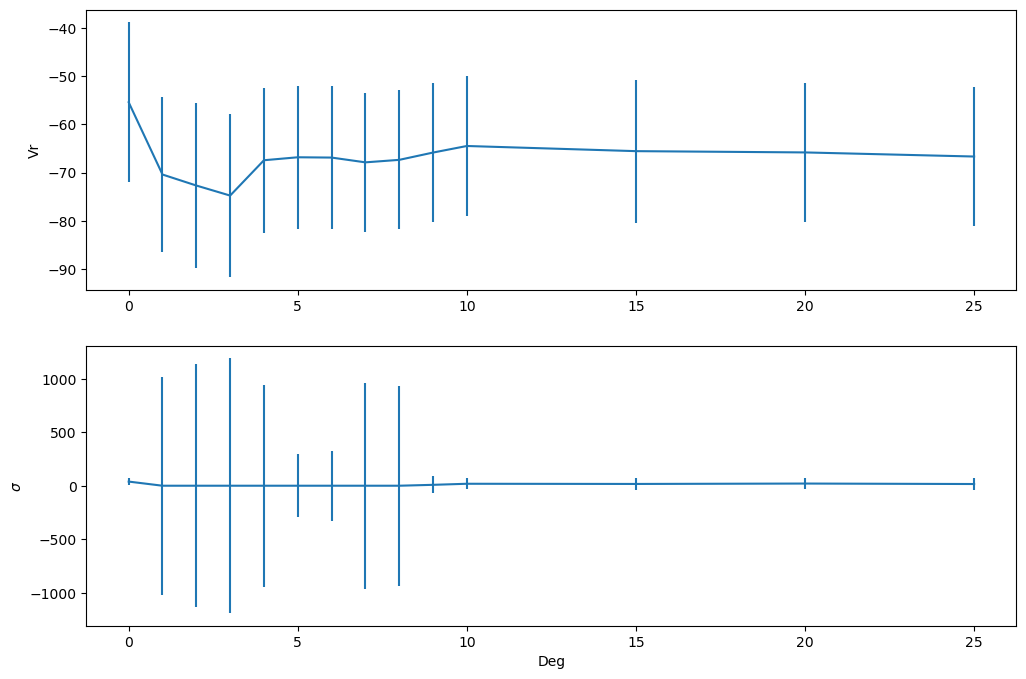

velocity: [-55, -70, -72, -74, -67, -66, -66, -67, -67, -65, -64, -65, -65, -66]
sigma:    [39, 0, 0, 0, 0, 0, 0, 0, 0, 9, 18, 17, 20, 16]


In [4]:
deg_kinem = np.asarray([0,1,2,3,4,5,6,7,8,9,10,15,20,25])  #series of degrees to check

def process_deg_kinem(i):
    pp = ppxf(templates, galaxy, noise, velscale, start, goodpixels=goodPixels,
        plot=True, moments=moments, degree=i, mdegree=-1, vsyst=dv, lam=np.exp(ln_lam1),
        clean=False, regul=False, reg_dim=reg_dim, component=component,
        gas_component=gas_component, gas_names=gas_names)

    vr = pp.sol[0][0]
    evr = pp.error[0][0] * np.sqrt(pp.chi2)
    sig = pp.sol[0][1]
    esig = pp.error[0][1] * np.sqrt(pp.chi2)
    return vr, evr, sig, esig

def run_deg_kinem(deg_kinem):
    results = []
    with Pool() as pool:
        for result in pool.imap(process_deg_kinem, range(len(deg_kinem))):
            results.append(result)
    
    vr = [result[0] for result in results]
    evr = [result[1] for result in results]
    sig = [result[2] for result in results]
    esig = [result[3] for result in results]
    return vr, evr, sig, esig

vr, evr, sig, esig = run_deg_kinem(deg_kinem)

clear_output()

fig = plt.figure(1, figsize=(12, 8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.errorbar(deg_kinem, vr, yerr=evr)
ax1.set_ylabel("Vr")

ax2.errorbar(deg_kinem, sig, yerr=esig)
ax2.set_ylabel("$\sigma$")
ax2.set_xlabel("Deg")
if write_out:
    plt.savefig(out_dir+'deg_k.png')
plt.show()

print(f"velocity: {np.int0(vr).tolist()}")
print(f"sigma:    {np.int0(sig).tolist()}")

### Choose Kinematic Degree

Update `deg_k` with best fit from the above code block 

In [5]:
deg_k = 10

### Multiplicative Degree

Run as is.

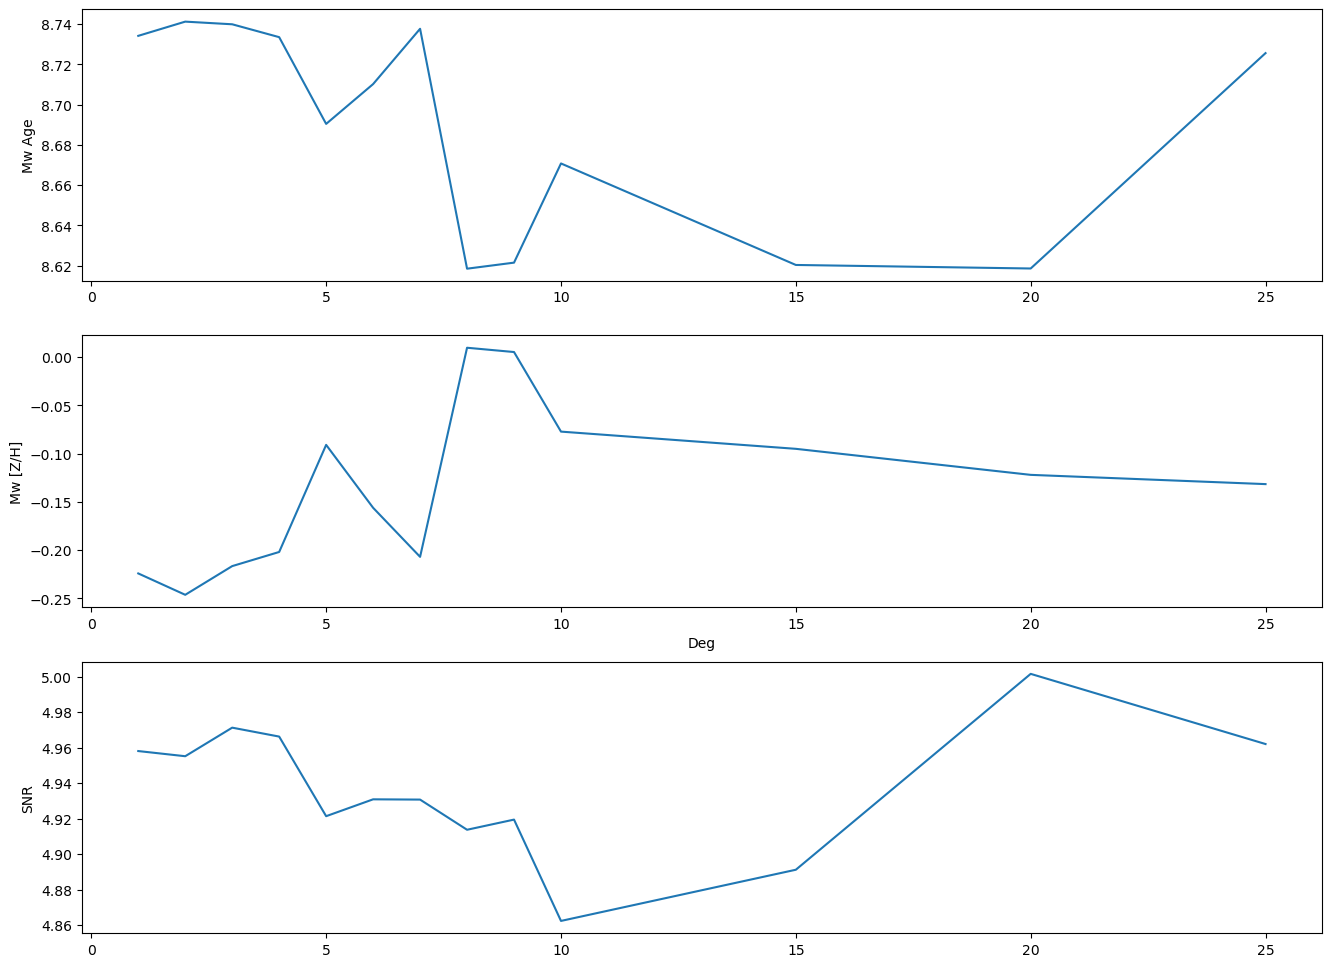

In [6]:
deg_pop = np.asarray([1,2,3,4,5,6,7,8,9,10,15,20,25])  #series of degrees to check

########## Once we select the degree for the kinematics
pp = ppxf(templates, galaxy, noise, velscale, start, goodpixels=goodPixels,
    plot=False, moments=moments, degree=deg_k, mdegree=-1, vsyst=dv, lam=np.exp(ln_lam1),
    clean=False, regul=False, reg_dim=reg_dim, component=component,
    gas_component=gas_component, gas_names=gas_names)  # ,velscale_ratio=velscale_ratio)

noise1 = noise * np.sqrt(pp.chi2)

def process_deg_pop(i):
    pp1 = ppxf(templates, galaxy, noise1, velscale, [pp.sol[0], pp.sol[1], pp.sol[2]], fixed=fixed, goodpixels=goodPixels,
        plot=False, moments=moments, degree=deg_k, mdegree=deg_pop[i], vsyst=dv, lam=np.exp(ln_lam1),
        clean=True, regul=False, reg_dim=reg_dim, component=component,
        gas_component=gas_component, gas_names=gas_names)#,velscale_ratio=velscale_ratio)

    weights = pp1.weights[~gas_component]
    weights = weights.reshape(reg_dim)/weights.sum()
    mwt = sps.mean_age_metal(weights)[0]
    mwz = sps.mean_age_metal(weights)[1]
    snr = np.median(pp1.bestfit) / np.std(galaxy - pp1.bestfit)
    return mwt, mwz, snr

def run_deg_pop(deg_pop):
    results = []
    with Pool() as pool:
        for result in pool.imap(process_deg_pop, range(len(deg_pop))):
            results.append(result)
    
    mwt = [result[0] for result in results]
    mwz = [result[1] for result in results]
    snr = [result[2] for result in results]
    return mwt, mwz, snr

mwt, mwz, snr = run_deg_pop(deg_pop)

clear_output()

fig = plt.figure(2, figsize=(16, 12))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.errorbar(deg_pop, mwt)
ax1.set_ylabel("Mw Age")

ax2.errorbar(deg_pop, mwz)
ax2.set_ylabel("Mw [Z/H]")

ax3.errorbar(deg_pop, snr)
ax3.set_ylabel("SNR")

ax2.set_xlabel("Deg")
if write_out:
    plt.savefig(out_dir+'deg_p.png')
plt.show()

### Choose Multiplicative Degree

Update `deg_p` with best fit from the above code block 

In [7]:
deg_p = 10

### Best Fit (No Regularisation)

record age and metalicity

Outliers: 5
Outliers: 5
 Best Fit:       Vel     sigma
 comp.  0:       -65        19
 comp.  1:       -72         1
 comp.  2:       -67         1
chi2/DOF: 0.9533; DOF: 1460; degree = 10; mdegree = 10
method = capfit; Jac calls: 4; Func calls: 125; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 6/155
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                Hdelta      0.000      0.43     -72     1
Comp:  1                Hgamma      1.176      0.42     -72     1
Comp:  1                 Hbeta      0.000      0.39     -72     1
Comp:  1              HeII4687     0.3531      0.40     -72     1
Comp:  2          [OIII]5007_d      1.495      0.49     -67     1
-----------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

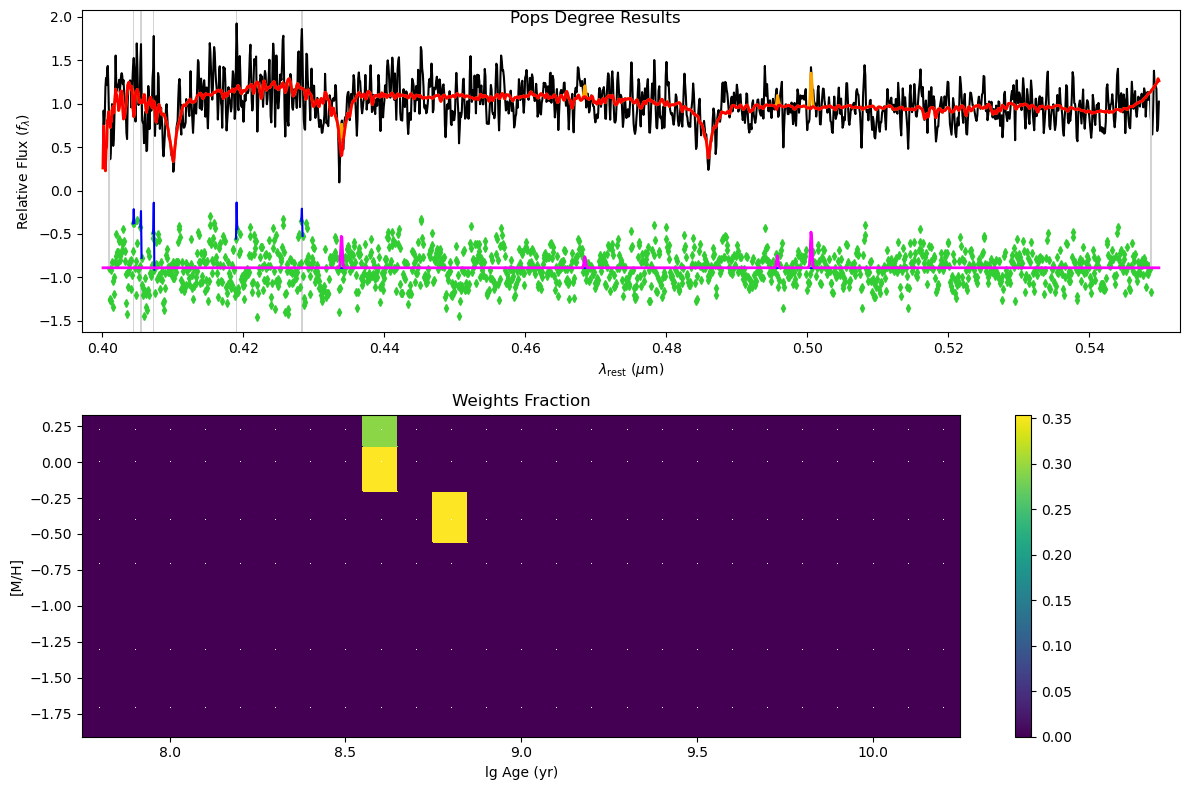

Weighted <lg_age> [yr]: 8.67
Weighted <[M/H]>: -0.0772
deg_k: 10
deg_p: 10
zi: -6.8e-05
fwhm: 2.5277777777777777
region: all_minus_10
file: mean_NCS.fits
wave_min: 4000
wave_max: 5500


In [8]:
pp1 = ppxf(templates, galaxy, noise1, velscale, [pp.sol[0], pp.sol[1], pp.sol[2]], fixed=fixed, goodpixels=goodPixels,
    plot=True, moments=moments, degree=deg_k, mdegree=deg_p, vsyst=dv, lam=np.exp(ln_lam1),
    clean=True, regul=False, reg_dim=reg_dim, component=component,
    gas_component=gas_component, gas_names=gas_names)  # ,velscale_ratio=velscale_ratio)

plt.clf()
plt.figure(figsize=(12, 8))
plt.subplot(211)
pp1.plot()
plt.subplot(212)
weights = pp1.weights[~gas_component]
weights = weights.reshape(reg_dim)/weights.sum()
sps.plot(weights)
plt.tight_layout()
plt.suptitle("Pops Degree Results")
if write_out:
    plt.savefig(out_dir+'fit_noreg.png')
plt.show()

mwt, mwz = sps.mean_age_metal(weights)
snr = np.median(pp1.bestfit) / np.std(galaxy - pp1.bestfit)
plt.show()

print(f'deg_k: {deg_k}')
print(f'deg_p: {deg_p}')
print(f'zi: {zi}')
print(f'fwhm: {FWHM_data}')
print(f'region: {region}')
print(f'file: {path.basename(fittable_file)}')
print(f'wave_min: {wave_min}')
print(f'wave_max: {wave_max}')

### Regularisation

After running, return to *Model Parameters* and update `reg_val` with best fit

In [ ]:
##### Select the thing from above than uncomment below and start playing around with regularisations

##### and we fix the pop deg to look for the regularization
pp1 = ppxf.ppxf.ppxf(templates, galaxy, noise1, VelScale, [pp.sol[0], pp.sol[1]], fixed=fixed, goodpixels=goodPixels,
       plot=True, moments=moments, degree=deg_k, mdegree=deg_p, vsyst=dv, lam=wave,
       clean=True, regul=False, reg_dim=reg_dim, component=component,
       gas_component=gas_component, gas_names=gas_names)  # ,velscale_ratio=velscale_ratio)
plt.clf()
plt.subplot(211)
pp1.plot()
plt.subplot(212)
weights = pp1.weights[~gas_component]
weights = weights.reshape(reg_dim)/weights.sum()
miles.plot(weights)
plt.tight_layout()
plt.suptitle("Pops Degree Results")
plt.show()

mwt, mwz = miles.mean_age_metal(weights)
snr = np.median(pp1.bestfit) / np.std(galaxy - pp1.bestfit)
plt.show()

######## and now we change the regul parameter until reduced and absolute are the same
regul_err = np.asarray([1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001])
# regul_err = np.asarray([0.000009, 0.000008, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002])
# regul_err = np.asarray([0.00009, 0.00008, 0.00007, 0.00006, 0.00005, 0.00004, 0.00003, 0.00002])
# regul_err = np.asarray([0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002])
# regul_err = np.asarray([0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02])
# regul_err = np.asarray([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])

for i in range(len(regul_err)):
    if i == 0:
        mwt = np.zeros(len(regul_err))
        mwz = np.zeros(len(regul_err))
        lwt = np.zeros(len(regul_err))
        lwz = np.zeros(len(regul_err))
        snr = np.zeros(len(regul_err))
        red_chi = np.zeros(len(regul_err))
        reg_chi = np.zeros(len(regul_err))
        des_chi = np.zeros(len(regul_err))
        cur_chi = np.zeros(len(regul_err))

    pp2 = ppxf.ppxf.ppxf(templates, galaxy, noise1, VelScale, [pp.sol[0], pp.sol[1]], fixed=fixed, goodpixels=goodPixels,
        plot=False,
        moments=moments, degree=deg_k, mdegree=deg_p, vsyst=dv, lam=wave, clean=True,
        regul=1. / regul_err[i], reg_dim=reg_dim,
        component=component, gas_component=gas_component,
        gas_names=gas_names)  # ,velscale_ratio=velscale_ratio)

    weights = pp2.weights[~gas_component]
    weights = weights.reshape(reg_dim) / weights.sum()
    mwt[i], mwz[i] = miles.mean_age_metal(weights)
    snr[i] = np.median(pp2.bestfit) / np.std(galaxy - pp2.bestfit)
    red_chi[i] = pp2.chi2
    reg_chi[i] = pp2.chi2 * goodPixels.size
    des_chi[i] = np.sqrt(2 * goodPixels.size)
    cur_chi[i] = (pp2.chi2 - pp1.chi2) * goodPixels.size
    print('The desired chi was %.8g' % des_chi[i])
    print('The current chi was %.8g' % cur_chi[i])

    plt.clf()
    plt.subplot(211)
    pp2.plot()
    plt.subplot(212)
    miles.plot(weights)
    plt.tight_layout()
    plt.suptitle("The Regularisation_err was %.5f" % regul_err[i])
    plt.show()
    time.sleep(5)
    plt.close()

    data = [regul_err, red_chi, reg_chi, des_chi, cur_chi, mwt, mwz, snr]

    print('The regul_error was %.8f' % regul_err[i])

In [ ]:
from ppxf_kinematics import ppxf_kinematics
ppxf_kinematics(fittable_file, FWHM_data, deg_k, wav_min, wav_max, fit='all', mdegree=4)